# Laboratorio: Random Forest para predecir TCH (Toneladas de Caña por Hectárea)
**Objetivo:** entrenar y evaluar un modelo de **Random Forest Regressor** que predice **TCH** a partir de variables agronómicas y económicas. El énfasis es didáctico: flujo completo (dataset sintético → entrenamiento → evaluación → interpretación).

## 1) Requisitos y preparación
- Este notebook funciona en VS Code / Jupyter / Databricks.
- Si falta `scikit-learn`, instálalo (ejecuta la celda siguiente).

In [ ]:

# Si necesitas instalar scikit-learn en tu entorno local descomenta esta línea:
# !pip install scikit-learn pandas matplotlib


## 2) Importar librerías

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

np.random.seed(42)


## 3) Generación de dataset sintético
Variables explicativas (features):
- `lluvia_mm` (800–2000)
- `humedad_suelo` (40–80)
- `fertilizacion` (100–300)
- `horas_sol` (5–12)
- `costo_insumos` (400–900)
- `mano_obra` (300–700)

Variable objetivo (target): **TCH**

La fórmula base agrega ruido para representar variabilidad real.

In [3]:

n = 400  # tamaño moderado para ejecución rápida
df = pd.DataFrame({
    'lluvia_mm': np.random.uniform(800, 2000, n),
    'humedad_suelo': np.random.uniform(40, 80, n),
    'fertilizacion': np.random.uniform(100, 300, n),
    'horas_sol': np.random.uniform(5, 12, n),
    'costo_insumos': np.random.uniform(400, 900, n),
    'mano_obra': np.random.uniform(300, 700, n)
})

# TCH como combinación lineal + ruido (para un ejemplo didáctico)
ruido = np.random.normal(0, 5, n)
df['TCH'] = (
    0.02 * df['lluvia_mm'] +
    0.40 * df['humedad_suelo'] +
    0.10 * df['fertilizacion'] +
    0.80 * df['horas_sol'] -
    0.03 * df['costo_insumos'] -
    0.02 * df['mano_obra'] +
    ruido
)

df.head()


,lluvia_mm,humedad_suelo,fertilizacion,horas_sol,costo_insumos,mano_obra,TCH
0,1249.448143,44.124955,241.447727,10.307842,495.933662,404.682273,49.247496
1,1940.857168,76.102116,130.507809,5.172108,561.685781,398.791520,60.573944
2,1678.392730,60.210095,215.257672,5.154865,513.328201,662.501832,46.234478
3,1518.390181,73.058299,221.343009,7.265272,577.498153,399.818480,58.186977
4,987.222369,52.801984,184.826134,8.420502,434.711921,408.779890,49.691559


## 4) Separar datos en entrenamiento/prueba

In [4]:

X = df.drop(columns=['TCH'])
y = df['TCH']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape


((280, 6), (120, 6))

## 5) Entrenamiento del modelo Random Forest

In [6]:

rf = RandomForestRegressor(
    n_estimators=120,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


,n_estimators,120
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6) Predicción y evaluación
Métricas:
- **R²**: explica qué proporción de la varianza del TCH captura el modelo (1.0 es perfecto).
- **MAE**: error absoluto medio en unidades de TCH (más bajo es mejor).

In [7]:

y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print({'R2': round(r2, 3), 'MAE': round(mae, 2)})


{'R2': 0.749, 'MAE': 4.81}


## 7) Importancia de variables (interpretación)
La **importancia** indica cuánto contribuye cada variable a reducir el error en el bosque aleatorio.

In [8]:

imp = pd.DataFrame({
    'variable': X.columns,
    'importancia': rf.feature_importances_
}).sort_values('importancia', ascending=False).reset_index(drop=True)
imp


,variable,importancia
0,lluvia_mm,0.372769
1,fertilizacion,0.299174
2,humedad_suelo,0.138066
3,costo_insumos,0.090881
4,mano_obra,0.065922
5,horas_sol,0.033189


### Gráfico: Importancia de variables

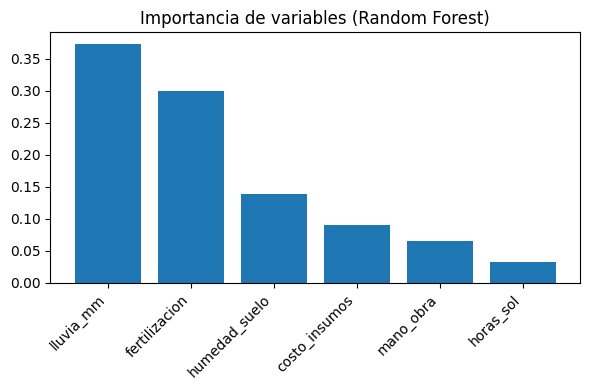

In [9]:

plt.figure(figsize=(6,4))
plt.bar(imp['variable'], imp['importancia'])
plt.title('Importancia de variables (Random Forest)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 8) Mini análisis de sensibilidad (What-if)
Fijamos todas las variables en su mediana y variamos **una** para ver el efecto esperado en TCH.
Esto **no** es un PDP formal, pero ilustra la idea para clase.

Qué es un PDP?
Es una técnica de interpretabilidad de modelos de Machine Learning que muestra cómo cambia la predicción promedio del modelo cuando variamos una o dos variables específicas, manteniendo las demás variables fijas (o promediadas sobre toda la distribución de datos).

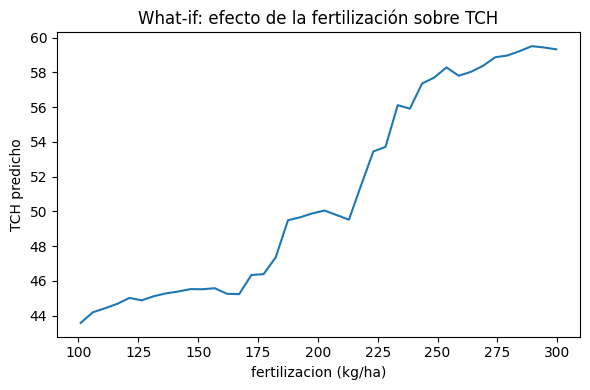

In [11]:

medianas = X.median()

def what_if(feature, low, high, steps=30):
    xs = np.linspace(low, high, steps)
    X_base = pd.DataFrame([medianas.values]*steps, columns=X.columns)
    X_base[feature] = xs
    y_hat = rf.predict(X_base)
    return xs, y_hat

# Ejemplo con fertilización
xs, y_hat = what_if('fertilizacion', X['fertilizacion'].min(), X['fertilizacion'].max(), 40)

plt.figure(figsize=(6,4))
plt.plot(xs, y_hat)
plt.xlabel('fertilizacion (kg/ha)')
plt.ylabel('TCH predicho')
plt.title('What-if: efecto de la fertilización sobre TCH')
plt.tight_layout()
plt.show()


## 9) Visualización simple: relación variable vs TCH

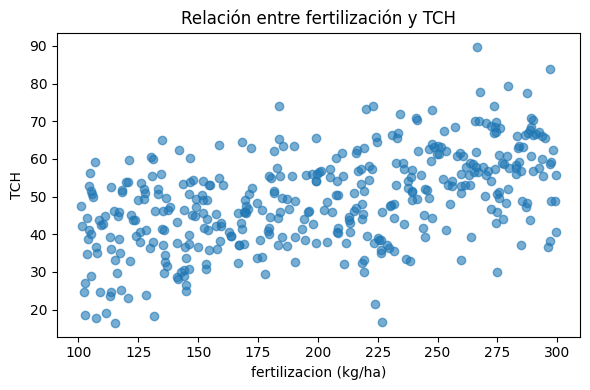

In [12]:

plt.figure(figsize=(6,4))
plt.scatter(df['fertilizacion'], df['TCH'], alpha=0.6)
plt.xlabel('fertilizacion (kg/ha)')
plt.ylabel('TCH')
plt.title('Relación entre fertilización y TCH')
plt.tight_layout()
plt.show()


## 10) Actividad para entregar
1. Reporta **R²** y **MAE** con una breve interpretación (2–3 líneas).
2. Cambia `n_estimators` a 40 y 300. ¿Cómo afecta a R² y MAE?
3. Repite el *what-if* con `lluvia_mm` y `humedad_suelo`.
4. ¿Cuáles son las **tres variables** más importantes? Relaciónalas con decisiones de **costo/inversión**.
5. (Opcional) Guarda el modelo con `joblib` y carga para predecir sobre nuevos lotes.